In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/anime.csv')
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


as we see there ar missing values so we will fill the missing values with mean for numeric column and unknown for categorical

In [ ]:
df['genre'].fillna('Unknown', inplace=True)
df['type'].fillna('Other', inplace=True)
df['rating'].fillna(df['rating'].mean(), inplace=True)

           anime_id        rating       members
count  12294.000000  12294.000000  1.229400e+04
mean   14058.221653      6.473902  1.807134e+04
std    11455.294701      1.017096  5.482068e+04
min        1.000000      1.670000  5.000000e+00
25%     3484.250000      5.900000  2.250000e+02
50%    10260.500000      6.550000  1.550000e+03
75%    24794.500000      7.170000  9.437000e+03
max    34527.000000     10.000000  1.013917e+06
type
TV         3787
OVA        3311
Movie      2348
Special    1676
ONA         659
Music       488
Other        25
Name: count, dtype: int64
genre
Hentai                   823
Comedy                   523
Music                    301
Kids                     199
Comedy, Slice of Life    179
Name: count, dtype: int64


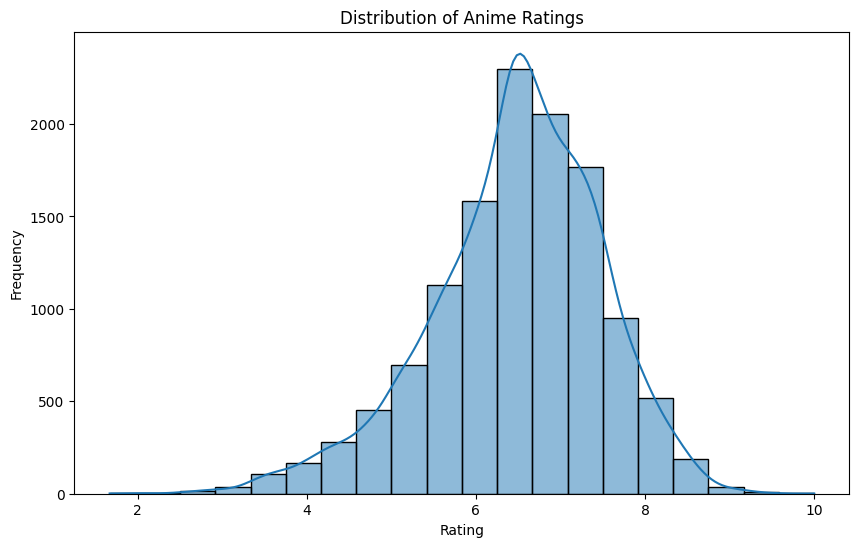

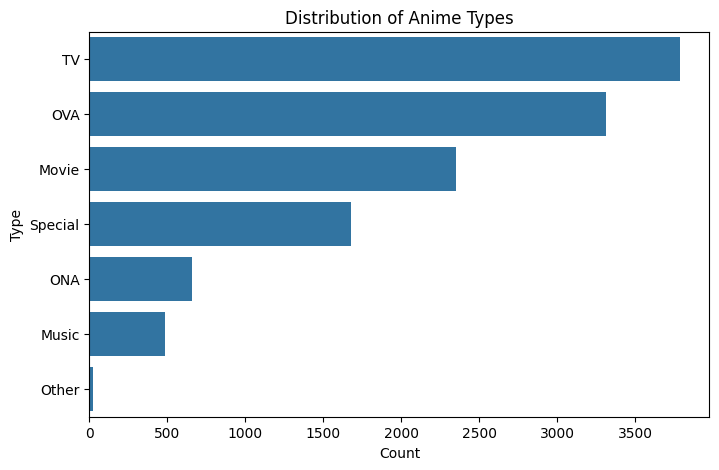

In [ ]:
# Summary statistics
print(df.describe())

# Check unique values in categorical columns
print(df['type'].value_counts())
print(df['genre'].value_counts().head()) # Display top few genres due to many unique values

# Explore the distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribution of Anime Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Explore the distribution of anime types
plt.figure(figsize=(8, 5))
sns.countplot(y='type', data=df, order = df['type'].value_counts().index)
plt.title('Distribution of Anime Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

as we see there are more animes whose rating is above 6 whish tells frequency of the rating based on anime and we see the type of anime present in the data set

# Feature Extraction:

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Features for similarity: genre, type, and rating
features = ['genre', 'type', 'rating']

# 1. Genre: It's a multi-label categorical feature. Use MultiLabelBinarizer.
# First, split the genre string into a list of genres
df['genre_list'] = df['genre'].apply(lambda x: x.split(', '))

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre_list'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

# 2. Type: It's a categorical feature. Use one-hot encoding.
type_encoded = pd.get_dummies(df['type'], prefix='type')

# 3. Rating: It's a numerical feature. Normalization might be useful.
# Useing Min-Max scaling to scale rating between 0 and 1.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['rating_scaled'] = scaler.fit_transform(df[['rating']])

# Combine the processed features
# We'll use genre_df, type_encoded, and the scaled rating.
# Ensure indices align before concatenating.
df_processed = pd.concat([genre_df, type_encoded, df['rating_scaled']], axis=1)

print("Processed features DataFrame shape:", df_processed.shape)
print(df_processed.head())


Processed features DataFrame shape: (12294, 52)
   Action  Adventure  Cars  Comedy  Dementia  Demons  Drama  Ecchi  Fantasy  \
0       0          0     0       0         0       0      1      0        0   
1       1          1     0       0         0       0      1      0        1   
2       1          0     0       1         0       0      0      0        0   
3       0          0     0       0         0       0      0      0        0   
4       1          0     0       1         0       0      0      0        0   

   Game  ...  Yaoi  Yuri  type_Movie  type_Music  type_ONA  type_OVA  \
0     0  ...     0     0        True       False     False     False   
1     0  ...     0     0       False       False     False     False   
2     0  ...     0     0       False       False     False     False   
3     0  ...     0     0       False       False     False     False   
4     0  ...     0     0       False       False     False     False   

   type_Other  type_Special  type_TV  rating

# Recommendation System:

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_anime(target_anime_name, df, df_processed, threshold=0.5, top_n=10):
  # Find the index of the target anime
  target_index = df[df['name'] == target_anime_name].index

  if len(target_index) == 0:
    print(f"Anime '{target_anime_name}' not found in the dataset.")
    return pd.DataFrame()

  target_index = target_index[0]

  # Calculate cosine similarity between the target anime and all other anime
  similarity_scores = cosine_similarity(df_processed.iloc[[target_index]], df_processed)

  # Get the similarity scores for the target anime
  similarity_scores = similarity_scores[0]

  # Get the indices of anime sorted by similarity score in descending order
  similar_anime_indices = similarity_scores.argsort()[::-1]

  # Filter out the target anime itself
  similar_anime_indices = similar_anime_indices[similar_anime_indices != target_index]

  # Filter based on the similarity threshold
  recommended_anime_indices = [i for i in similar_anime_indices if similarity_scores[i] >= threshold]

  # Get the top N recommended anime
  recommended_anime_indices = recommended_anime_indices[:top_n]

  # Return the recommended anime details
  return df.iloc[recommended_anime_indices][['name', 'genre', 'type', 'rating']]

#so i have created user define function now we will recommend based on tresh hold value
# Example :
target_anime = 'Death Note'
threshold_value = 0.7
recommendations = recommend_anime(target_anime, df, df_processed, threshold=threshold_value)

print(f"\nRecommended anime for '{target_anime}' with similarity threshold {threshold_value}:")
print(recommendations)

# Experiment with a different threshold
threshold_value_lower = 0.5
recommendations_lower_threshold = recommend_anime(target_anime, df, df_processed, threshold=threshold_value_lower)

print(f"\nRecommended anime for '{target_anime}' with similarity threshold {threshold_value_lower}:")
print(recommendations_lower_threshold)


Recommended anime for 'Death Note' with similarity threshold 0.7:
                                   name  \
981                     Mousou Dairinin   
144       Higurashi no Naku Koro ni Kai   
334           Higurashi no Naku Koro ni   
778                  Death Note Rewrite   
833            Jigoku Shoujo Mitsuganae   
2691  Yakushiji Ryouko no Kaiki Jikenbo   
6323            Saint Luminous Jogakuin   
445                    Mirai Nikki (TV)   
49              Boku dake ga Inai Machi   
436            Jigoku Shoujo Futakomori   

                                                  genre     type  rating  
981   Drama, Mystery, Police, Psychological, Superna...       TV    7.74  
144      Mystery, Psychological, Supernatural, Thriller       TV    8.41  
334   Horror, Mystery, Psychological, Supernatural, ...       TV    8.17  
778   Mystery, Police, Psychological, Supernatural, ...  Special    7.84  
833                Mystery, Psychological, Supernatural       TV    7.81  
2691     

# Evaluation:

In [ ]:
from sklearn.model_selection import train_test_split

X = df_processed

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Shape of the original features dataset:", X.shape)
print("Shape of the training features dataset:", X_train.shape)
print("Shape of the testing features dataset:", X_test.shape)

Shape of the original features dataset: (12294, 52)
Shape of the training features dataset: (9835, 52)
Shape of the testing features dataset: (2459, 52)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_recommendations(target_anime_name, df, df_processed, rec_threshold=0.7, rel_threshold=0.9, top_n=10):
    target_index = df[df['name'] == target_anime_name].index

    if not target_index.any():
        return {"precision": 0, "recall": 0, "f1_score": 0}

    target_index = target_index[0]
    similarity_scores = cosine_similarity(df_processed.iloc[[target_index]], df_processed)[0]
    relevant_indices = [i for i, score in enumerate(similarity_scores) if score >= rel_threshold and i != target_index]

    recommended_indices = recommend_anime(target_anime_name, df, df_processed, threshold=rec_threshold, top_n=len(df)).index[:top_n]
    all_indices = set(range(len(df))) - {target_index}

    y_true = [1 if i in relevant_indices else 0 for i in all_indices]
    y_pred = [1 if i in recommended_indices else 0 for i in all_indices]

    return {"precision": precision_score(y_true, y_pred), "recall": recall_score(y_true, y_pred), "f1_score": f1_score(y_true, y_pred)}

# Example on death note
target_anime = 'Death Note'
evaluation = evaluate_recommendations(target_anime, df, df_processed, rec_threshold=0.6, rel_threshold=0.75, top_n=13)
print(evaluation)

{'precision': 1.0, 'recall': 0.7647058823529411, 'f1_score': 0.8666666666666667}


- **Precision** – This measures the **accuracy** of recommendations. It tells you what proportion of the recommended items were actually relevant.
  - Formula: **Precision = (Relevant recommended items) / (Total recommended items)**
  - Higher precision means fewer irrelevant recommendations.

- **Recall** – This measures **coverage**, showing how many of the relevant items were successfully retrieved.
  - Formula: **Recall = (Relevant recommended items) / (Total relevant items available)**
  - High recall means you’re capturing most of what’s relevant.

- **F1-score** – This combines precision and recall into a single metric, offering a **balanced view** of the recommendation system’s effectiveness.
  - Formula: **F1-score = 2 × (Precision × Recall) / (Precision + Recall)**
  - A high F1-score suggests a good balance between precision and recall.



# Interview Questions:

**1. Can you explain the difference between user-based and item-based collaborative filtering?**

 **User-Based vs. Item-Based Collaborative Filtering**  
   - **User-Based Collaborative Filtering**: Finds similar users and recommends items based on shared preferences. If two users have rated or interacted with similar items in the past, one user might enjoy what the other has liked.
   - **Item-Based Collaborative Filtering**: Focuses on the relationship between items rather than users. If two items are frequently liked or bought together, recommending one to users who liked the other makes sense.

Item-based filtering is often more scalable since item relationships are relatively stable, while user-based filtering can struggle when there are many users with sparse interactions.



**2. What is collaborative filtering, and how does it work?**

Collaborative filtering is a technique used in recommendation systems to predict a user's interests based on patterns observed in other users. It operates under the assumption that if two users share similar preferences, one might enjoy items liked by the other.

### How It Works:
1. **Data Collection** – Users interact with items (e.g., rating movies, purchasing books).
2. **Similarity Calculation** – The system finds relationships either between users (User-Based Filtering) or items (Item-Based Filtering).
3. **Prediction & Recommendation** – Items are suggested based on past behaviors of similar users or items frequently paired together.

For example, if you like "Death Note" and many others who like "Death Note" also enjoy "Code Geass," you might get a recommendation for "Code Geass."
